# exp064
indoor cost minimization使ってみる

In [100]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import simdkalman
import optuna
import pyproj
from pyproj import Proj, transform
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, accuracy_score
pd.set_option('display.max_rows', 100)
from math import * 
import scipy.interpolate
import scipy.sparse

In [41]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [42]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

# utils

In [43]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [44]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [45]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [46]:
# ground_truth
def get_ground_truth():
    p = pathlib.Path(INPUT)
    gt_files = list(p.glob('train/*/*/ground_truth.csv'))

    gts = []
    for gt_file in gt_files:
        gts.append(pd.read_csv(gt_file))
    ground_truth = pd.concat(gts)

    return ground_truth

In [47]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [48]:
class train_result:
    def __init__(self, df):
        self.df = df
        self.gt = get_ground_truth()
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)

In [49]:
def get_data():
    base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
    sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
    ground_truth = get_ground_truth()
    return base_train, base_test, sample_sub, ground_truth

# データ取得

In [50]:
train = pd.read_csv('../output/exp045/train_ro_rog_kf_sp0_pm_ps.csv')
gt = pd.read_csv(INPUT + '/prep/ground_truth_train.csv')
degree = pd.read_csv('../output/prep/degree_pred_v002/train_degree_pred.csv')
dist = pd.read_csv('../output/prep/distance_pred_v002/train_distance_pred.csv')
sp0 = pd.read_csv('../output/prep/speed0_pred_v001/train_sp0_pred.csv')
gt['phone'] = gt['collectionName'] + '_' + gt['phoneName']

In [51]:
dist = dist.rename(columns={'pred': 'dist_pred'}) 

In [52]:
train = train.merge(degree[['phone', 'millisSinceGpsEpoch', 'calc_deg']], on=['phone', 'millisSinceGpsEpoch'], how='left')
train = train.merge(dist[['phone', 'millisSinceGpsEpoch', 'dist_pred']], on=['phone', 'millisSinceGpsEpoch'], how='left')
train = train.merge(sp0[['phone', 'millisSinceGpsEpoch', 'isSpeed0']], on=['phone', 'millisSinceGpsEpoch'], how='left')

In [53]:
train.loc[train['isSpeed0']==1, 'dist_pred'] = 0

In [54]:
train

collectionName        phoneName  millisSinceGpsEpoch     latDeg  \
0       2020-05-14-US-MTV-1           Pixel4        1273529463442  37.423582   
1       2020-05-14-US-MTV-1           Pixel4        1273529464442  37.423582   
2       2020-05-14-US-MTV-1           Pixel4        1273529465442  37.423582   
3       2020-05-14-US-MTV-1           Pixel4        1273529466442  37.423582   
4       2020-05-14-US-MTV-1           Pixel4        1273529467442  37.423583   
...                     ...              ...                  ...        ...   
131337  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760315000  37.334472   
131338  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760316000  37.334472   
131339  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760317000  37.334472   
131340  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760318000  37.334472   
131341  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760319000  37.334472   

            lngDeg                                phone  \
0      -122.094127           2020-05-14-US-MTV-1_Pixel4   
1      -122.094127           2020-05-14-US-MTV-1_Pixel4   
2      -122.094127           2020-05-14-US-MTV-1_Pixel4   
3      -122.094127           2020-05-14-US-MTV-1_Pixel4   
4      -122.094127           2020-05-14-US-MTV-1_Pixel4   
...            ...                                  ...   
131337 -121.899604  2021-04-29-US-SJC-2_SamsungS20Ultra   
131338 -121.899604  2021-04-29-US-SJC-2_SamsungS20Ultra   
131339 -121.899604  2021-04-29-US-SJC-2_SamsungS20Ultra   
131340 -121.899604  2021-04-29-US-SJC-2_SamsungS20Ultra   
131341 -121.899604  2021-04-29-US-SJC-2_SamsungS20Ultra   

        heightAboveWgs84EllipsoidM             x             y             z  \
0                             63.5 -2.694608e+06 -4.296551e+06  3.854871e+06   
1                             63.5 -2.694608e+06 -4.296551e+06  3.854871e+06   
2                             63.5 -2.694608e+06 -4.296551e+06  3.854871e+06   
3                             63.5 -2.694608e+06 -4.296551e+06  3.854871e+06   
4                             63.5 -2.694608e+06 -4.296552e+06  3.854870e+06   
...                            ...           ...           ...           ...   
131337                        63.5 -2.683178e+06 -4.310772e+06  3.847012e+06   
131338                        63.5 -2.683178e+06 -4.310772e+06  3.847012e+06   
131339                        63.5 -2.683178e+06 -4.310772e+06  3.847012e+06   
131340                        63.5 -2.683178e+06 -4.310772e+06  3.847012e+06   
131341                        63.5 -2.683178e+06 -4.310772e+06  3.847012e+06   

        ...     ydiff            zp     zdiff      dist          xnew  \
0       ...       NaN           NaN       NaN       NaN           NaN   
1       ...  0.000000  3.854871e+06  0.000000  0.000000           NaN   
2       ...  0.000000  3.854871e+06  0.000000  0.000000           NaN   
3       ...  0.000000  3.854871e+06  0.000000  0.000000           NaN   
4       ... -0.191047  3.854871e+06 -0.380402  0.490277 -2.694608e+06   
...     ...       ...           ...       ...       ...           ...   
131337  ...  0.000000  3.847012e+06  0.000000  0.000000           NaN   
131338  ...  0.000000  3.847012e+06  0.000000  0.000000           NaN   
131339  ...  0.000000  3.847012e+06  0.000000  0.000000           NaN   
131340  ...  0.000000  3.847012e+06  0.000000  0.000000           NaN   
131341  ...  0.000000  3.847012e+06  0.000000  0.000000           NaN   

                ynew          znew   calc_deg  dist_pred  isSpeed0  
0                NaN           NaN   0.981589        0.0         1  
1                NaN           NaN   0.787438        0.0         1  
2                NaN           NaN   0.705617        0.0         1  
3                NaN           NaN   0.645836        0.0         1  
4      -4.296551e+06  3.854871e+06   0.638460        0.0         1  
...              ...           ...        ...        ...       ...  
131337           NaN  

# 相対座標

In [55]:
# 楕円体
ELLIPSOID_GRS80 = 1 # GRS80
ELLIPSOID_WGS84 = 2 # WGS84

# 楕円体別の長軸半径と扁平率
GEODETIC_DATUM = {
    ELLIPSOID_GRS80: [
        6378137.0,         # [GRS80]長軸半径
        1 / 298.257222101, # [GRS80]扁平率
    ],
    ELLIPSOID_WGS84: [
        6378137.0,         # [WGS84]長軸半径
        1 / 298.257223563, # [WGS84]扁平率
    ],
}

# 反復計算の上限回数
ITERATION_LIMIT = 1000

'''
Vincenty法(順解法)
始点の座標(緯度経度)と方位角と距離から、終点の座標と方位角を求める
:param lat: 緯度
:param lon: 経度
:param azimuth: 方位角
:param distance: 距離
:param ellipsoid: 楕円体
:return: 終点の座標、方位角
'''
def vincenty_direct(lat, lon, azimuth, distance, ellipsoid=None):

    # 計算時に必要な長軸半径(a)と扁平率(ƒ)を定数から取得し、短軸半径(b)を算出する
    # 楕円体が未指定の場合はGRS80の値を用いる
    a, ƒ = GEODETIC_DATUM.get(ellipsoid, GEODETIC_DATUM.get(ELLIPSOID_WGS84))
    b = (1 - ƒ) * a

    # ラジアンに変換する(距離以外)
    φ1 = radians(lat)
    λ1 = radians(lon)
    α1 = radians(azimuth)
    s = distance

    sinα1 = sin(α1)
    cosα1 = cos(α1)

    # 更成緯度(補助球上の緯度)
    U1 = atan((1 - ƒ) * tan(φ1))

    sinU1 = sin(U1)
    cosU1 = cos(U1)
    tanU1 = tan(U1)

    σ1 = atan2(tanU1, cosα1)
    sinα = cosU1 * sinα1
    cos2α = 1 - sinα ** 2
    u2 = cos2α * (a ** 2 - b ** 2) / (b ** 2)
    A = 1 + u2 / 16384 * (4096 + u2 * (-768 + u2 * (320 - 175 * u2)))
    B = u2 / 1024 * (256 + u2 * (-128 + u2 * (74 - 47 * u2)))

    # σをs/(b*A)で初期化
    σ = s / (b * A)

    # 以下の計算をσが収束するまで反復する
    # 地点によっては収束しないことがあり得るため、反復回数に上限を設ける
    for i in range(ITERATION_LIMIT):
        cos2σm = cos(2 * σ1 + σ)
        sinσ = sin(σ)
        cosσ = cos(σ)
        Δσ = B * sinσ * (cos2σm + B / 4 * (cosσ * (-1 + 2 * cos2σm ** 2) - B / 6 * cos2σm * (-3 + 4 * sinσ ** 2) * (-3 + 4 * cos2σm ** 2)))
        σʹ = σ
        σ = s / (b * A) + Δσ

        # 偏差が.000000000001以下ならbreak
        if abs(σ - σʹ) <= 1e-12:
            break
    else:
        # 計算が収束しなかった場合はNoneを返す
        return None

    # σが所望の精度まで収束したら以下の計算を行う
    x = sinU1 * sinσ - cosU1 * cosσ * cosα1
    φ2 = atan2(sinU1 * cosσ + cosU1 * sinσ * cosα1, (1 - ƒ) * sqrt(sinα ** 2 + x ** 2))
    λ = atan2(sinσ * sinα1, cosU1 * cosσ - sinU1 * sinσ * cosα1)
    C = ƒ / 16 * cos2α * (4 + ƒ * (4 - 3 * cos2α))
    L = λ - (1 - C) * ƒ * sinα * (σ + C * sinσ * (cos2σm + C * cosσ * (-1 + 2 * cos2σm ** 2)))
    λ2 = L + λ1

    α2 = atan2(sinα, -x) + pi

    return {
        'lat': degrees(φ2),     # 緯度
        'lon': degrees(λ2),     # 経度
        'azimuth': degrees(α2), # 方位角
    }

In [56]:
def calc_coordinate_forward(df, a):
    df_index = list(df.index)
    for idx in df_index:
        b = 1 - a
        
        if idx == df.index[-1]-1:
            break
        
        if df.at[idx, 'phone'] != df.at[idx+1, 'phone']:
            continue

        
        lat_hat_t0 = df.at[idx, 'latDeg']
        lng_hat_t0 = df.at[idx, 'lngDeg']
        lat_hat_t1 = df.at[idx+1, 'latDeg']
        lng_hat_t1 = df.at[idx+1, 'lngDeg']
        deg = df.at[idx, 'calc_deg']
        speed = df.at[idx, 'dist_pred']
        
        res = vincenty_direct(lat_hat_t0, lng_hat_t0, deg, speed)
        if res:
            lat_rel = res['lat']
            lng_rel = res['lon']
            
            lat_new = lat_hat_t1 * a + lat_rel * b
            lng_new = lng_hat_t1 * a + lng_rel * b
            
            df.at[idx+1, 'latDeg'] = lat_new
            df.at[idx+1, 'lngDeg'] = lng_new
    
    df_index.reverse()
    for idx in df_index:
        if idx == df.index[0]:
            break
        
        if df.at[idx, 'phone'] != df.at[idx-1, 'phone']:
            continue
            
        lat_hat_t0 = df.at[idx, 'latDeg']
        lng_hat_t0 = df.at[idx, 'lngDeg']
        lat_hat_t1 = df.at[idx-1, 'latDeg']
        lng_hat_t1 = df.at[idx-1, 'lngDeg']
        deg = df.at[idx, 'calc_deg']
        speed = df.at[idx, 'dist_pred']
        
        # 角度を反転
        if deg < 180:
            deg += 180
        else:
            deg -= 180        
        
        res = vincenty_direct(lat_hat_t0, lng_hat_t0, deg, speed)
        if res:
            lat_rel = res['lat']
            lng_rel = res['lon']
            
            lat_new = lat_hat_t1 * a + lat_rel * b
            lng_new = lng_hat_t1 * a + lng_rel * b
            
            df.at[idx-1, 'latDeg'] = lat_new
            df.at[idx-1, 'lngDeg'] = lng_new
        
        
    return df    

# 後処理前

In [57]:
df = train[train['phone']=='2021-04-22-US-SJC-1_Pixel4'].copy()

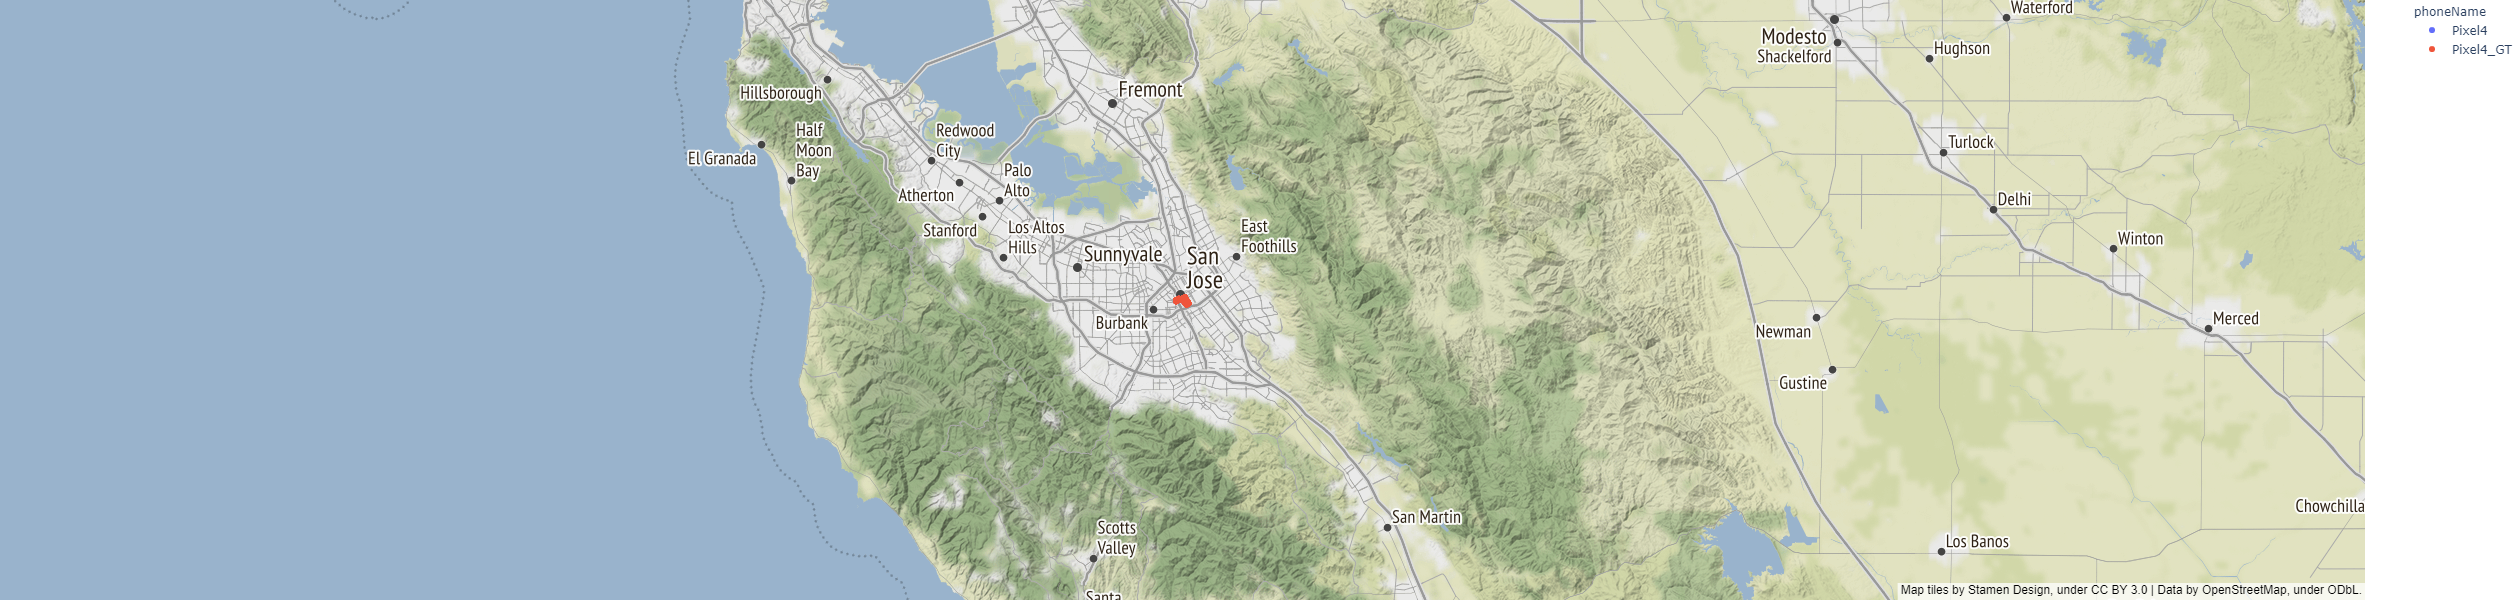

In [58]:
train_result(df).viz_map('2021-04-22-US-SJC-1', show_bl=False)

In [59]:
train_result(df).score

10.941342505897023

# 自作後処理

In [60]:
target_df = df.copy()
target_df = calc_coordinate_forward(target_df, 0.5)

In [61]:
target_df

collectionName phoneName  millisSinceGpsEpoch     latDeg  \
103937  2021-04-22-US-SJC-1    Pixel4        1303160575446  37.334583   
103938  2021-04-22-US-SJC-1    Pixel4        1303160576446  37.334582   
103939  2021-04-22-US-SJC-1    Pixel4        1303160577446  37.334582   
103940  2021-04-22-US-SJC-1    Pixel4        1303160578446  37.334583   
103941  2021-04-22-US-SJC-1    Pixel4        1303160579446  37.334583   
...                     ...       ...                  ...        ...   
106822  2021-04-22-US-SJC-1    Pixel4        1303163462446  37.334639   
106823  2021-04-22-US-SJC-1    Pixel4        1303163463446  37.334639   
106824  2021-04-22-US-SJC-1    Pixel4        1303163464446  37.334639   
106825  2021-04-22-US-SJC-1    Pixel4        1303163465446  37.334639   
106826  2021-04-22-US-SJC-1    Pixel4        1303163466446  37.334639   

            lngDeg                       phone  heightAboveWgs84EllipsoidM  \
103937 -121.899417  2021-04-22-US-SJC-1_Pixel4                        63.5   
103938 -121.899417  2021-04-22-US-SJC-1_Pixel4                        63.5   
103939 -121.899417  2021-04-22-US-SJC-1_Pixel4                        63.5   
103940 -121.899416  2021-04-22-US-SJC-1_Pixel4                        63.5   
103941 -121.899416  2021-04-22-US-SJC-1_Pixel4                        63.5   
...            ...                         ...                         ...   
106822 -121.899357  2021-04-22-US-SJC-1_Pixel4                        63.5   
106823 -121.899357  2021-04-22-US-SJC-1_Pixel4                        63.5   
106824 -121.899357  2021-04-22-US-SJC-1_Pixel4                        63.5   
106825 -121.899357  2021-04-22-US-SJC-1_Pixel4                        63.5   
106826 -121.899357  2021-04-22-US-SJC-1_Pixel4                        63.5   

                   x             y             z  ...     ydiff            zp  \
103937 -2.683160e+06 -4.310775e+06  3.847021e+06  ...       NaN           NaN   
103938 -2.683160e+06 -4.310775e+06  3.847021e+06  ...  0.000000  3.847021e+06   
103939 -2.683160e+06 -4.310775e+06  3.847021e+06  ... -0.043778  3.847021e+06   
103940 -2.683160e+06 -4.310775e+06  3.847021e+06  ...  0.000000  3.847021e+06   
103941 -2.683160e+06 -4.310775e+06  3.847021e+06  ...  0.000000  3.847021e+06   
...              ...           ...           ...  ...       ...           ...   
106822 -2.683154e+06 -4.310774e+06  3.847026e+06  ...  0.000000  3.847026e+06   
106823 -2.683154e+06 -4.310774e+06  3.847026e+06  ...  0.000000  3.847026e+06   
106824 -2.683154e+06 -4.310774e+06  3.847026e+06  ...  0.000000  3.847026e+06   
106825 -2.683154e+06 -4.310774e+06  3.847026e+06  ...  0.000000  3.847026e+06   
106826 -2.683154e+06 -4.310774e+06  3.847026e+06  ...  0.000000  3.847026e+06   

           zdiff      dist          xnew          ynew          znew  \
103937       NaN       NaN           NaN           NaN           NaN   
103938  0.000000  0.000000           NaN           NaN           NaN   
103939  0.018598  0.108196 -2.683160e+06 -4.310775e+06  3.847021e+06   
103940  0.000000  0.000000           NaN           NaN           NaN   
103941  0.000000  0.000000           NaN           NaN           NaN   
...          ...       ...           ...           ...           ...   
106822  0.000000  0.000000           NaN           NaN           NaN   
106823  0.000000  0.000000           NaN           NaN           NaN   
106824  0.000000  0.000000           NaN           NaN           NaN   
106825  0.000000  0.000000           NaN           NaN           NaN   
106826  0.000000  0.000000           NaN           NaN           NaN   

         calc_deg  dist_pred  isSpeed0  
103937  35.296870        0.0         1  
103938  35.241133        0.0         1  
103939  36.144384        0.0         1  
103940  36.580848        0.0         1  
103941  36.755717        0.0         1  
...           ...        ...       ...  
106822  40.139916        0.0         1  
106823  38.980346        0.0     

In [62]:
train_result(target_df).score

10.35811630870609

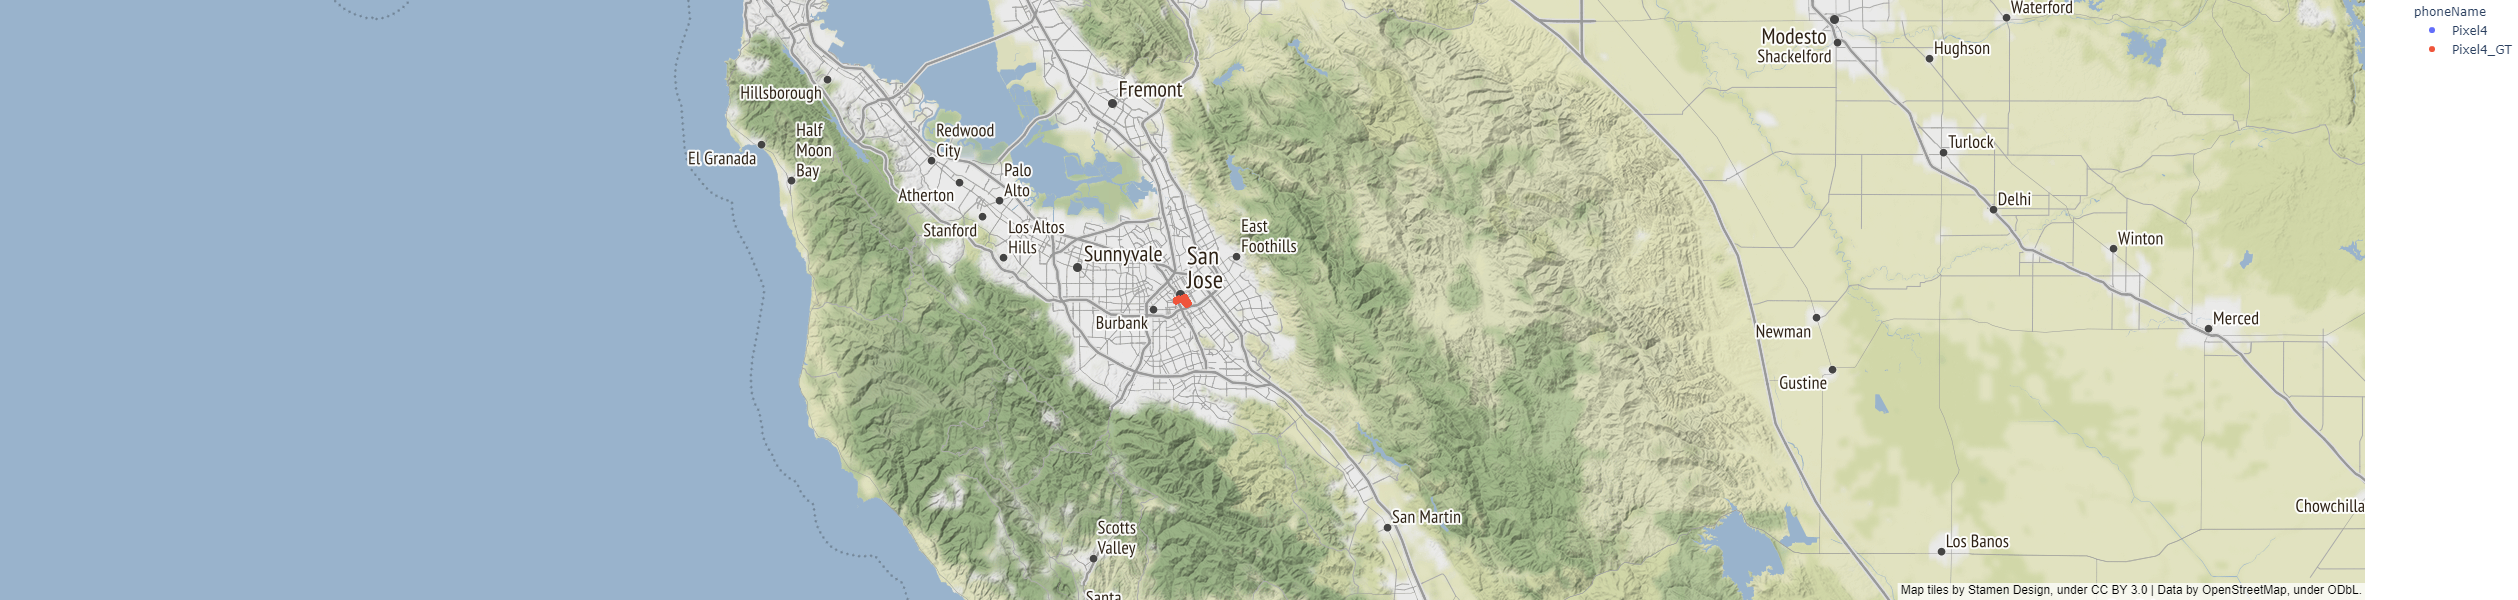

In [63]:
train_result(target_df).viz_map('2021-04-22-US-SJC-1', show_bl=False)

# indoor cost minimization

In [66]:
target_df2 = df.copy()

In [67]:
target_df2

collectionName phoneName  millisSinceGpsEpoch     latDeg  \
103937  2021-04-22-US-SJC-1    Pixel4        1303160575446  37.334583   
103938  2021-04-22-US-SJC-1    Pixel4        1303160576446  37.334583   
103939  2021-04-22-US-SJC-1    Pixel4        1303160577446  37.334582   
103940  2021-04-22-US-SJC-1    Pixel4        1303160578446  37.334583   
103941  2021-04-22-US-SJC-1    Pixel4        1303160579446  37.334583   
...                     ...       ...                  ...        ...   
106822  2021-04-22-US-SJC-1    Pixel4        1303163462446  37.334639   
106823  2021-04-22-US-SJC-1    Pixel4        1303163463446  37.334639   
106824  2021-04-22-US-SJC-1    Pixel4        1303163464446  37.334639   
106825  2021-04-22-US-SJC-1    Pixel4        1303163465446  37.334639   
106826  2021-04-22-US-SJC-1    Pixel4        1303163466446  37.334639   

            lngDeg                       phone  heightAboveWgs84EllipsoidM  \
103937 -121.899416  2021-04-22-US-SJC-1_Pixel4                        63.5   
103938 -121.899416  2021-04-22-US-SJC-1_Pixel4                        63.5   
103939 -121.899421  2021-04-22-US-SJC-1_Pixel4                        63.5   
103940 -121.899415  2021-04-22-US-SJC-1_Pixel4                        63.5   
103941 -121.899415  2021-04-22-US-SJC-1_Pixel4                        63.5   
...            ...                         ...                         ...   
106822 -121.899357  2021-04-22-US-SJC-1_Pixel4                        63.5   
106823 -121.899357  2021-04-22-US-SJC-1_Pixel4                        63.5   
106824 -121.899357  2021-04-22-US-SJC-1_Pixel4                        63.5   
106825 -121.899357  2021-04-22-US-SJC-1_Pixel4                        63.5   
106826 -121.899357  2021-04-22-US-SJC-1_Pixel4                        63.5   

                   x             y             z  ...     ydiff            zp  \
103937 -2.683160e+06 -4.310775e+06  3.847021e+06  ...       NaN           NaN   
103938 -2.683160e+06 -4.310775e+06  3.847021e+06  ...  0.000000  3.847021e+06   
103939 -2.683160e+06 -4.310775e+06  3.847021e+06  ... -0.043778  3.847021e+06   
103940 -2.683160e+06 -4.310775e+06  3.847021e+06  ...  0.000000  3.847021e+06   
103941 -2.683160e+06 -4.310775e+06  3.847021e+06  ...  0.000000  3.847021e+06   
...              ...           ...           ...  ...       ...           ...   
106822 -2.683154e+06 -4.310774e+06  3.847026e+06  ...  0.000000  3.847026e+06   
106823 -2.683154e+06 -4.310774e+06  3.847026e+06  ...  0.000000  3.847026e+06   
106824 -2.683154e+06 -4.310774e+06  3.847026e+06  ...  0.000000  3.847026e+06   
106825 -2.683154e+06 -4.310774e+06  3.847026e+06  ...  0.000000  3.847026e+06   
106826 -2.683154e+06 -4.310774e+06  3.847026e+06  ...  0.000000  3.847026e+06   

           zdiff      dist          xnew          ynew          znew  \
103937       NaN       NaN           NaN           NaN           NaN   
103938  0.000000  0.000000           NaN           NaN           NaN   
103939  0.018598  0.108196 -2.683160e+06 -4.310775e+06  3.847021e+06   
103940  0.000000  0.000000           NaN           NaN           NaN   
103941  0.000000  0.000000           NaN           NaN           NaN   
...          ...       ...           ...           ...           ...   
106822  0.000000  0.000000           NaN           NaN           NaN   
106823  0.000000  0.000000           NaN           NaN           NaN   
106824  0.000000  0.000000           NaN           NaN           NaN   
106825  0.000000  0.000000           NaN           NaN           NaN   
106826  0.000000  0.000000           NaN           NaN           NaN   

         calc_deg  dist_pred  isSpeed0  
103937  35.296870        0.0         1  
103938  35.241133        0.0         1  
103939  36.144384        0.0         1  
103940  36.580848        0.0         1  
103941  36.755717        0.0         1  
...           ...        ...       ...  
106822  40.139916        0.0         1  
106823  38.980346        0.0     

## 元座標の違いで移動後座標の計算結果がどの程度変わるか

In [78]:
lat = target_df2['latDeg'].min()
lng = target_df2['lngDeg'].min()

res1 = vincenty_direct(lat, lng, 40, 10, ellipsoid=None)
print(res1['lat'] - lat, res1['lon'] - lng)

6.902305817391152e-05 7.252712583749599e-05


In [79]:
lat = target_df2['latDeg'].max()
lng = target_df2['lngDeg'].max()

res2 = vincenty_direct(lat, lng, 40, 10, ellipsoid=None)
print(res2['lat'] - lat, res2['lon'] - lng)

6.90229519406671e-05 7.253585707189814e-05


In [80]:
lat = train['latDeg'].min()
lng = train['lngDeg'].min()

res3 = vincenty_direct(lat, lng, 40, 10, ellipsoid=None)
print(res3['lat'] - lat, res3['lon'] - lng)

6.902312416912082e-05 7.252170109950384e-05


In [81]:
lat = train['latDeg'].max()
lng = train['lngDeg'].max()

res4 = vincenty_direct(lat, lng, 40, 10, ellipsoid=None)
print(res4['lat'] - lat, res4['lon'] - lng)

6.901881376819574e-05 7.287851859416605e-05


In [82]:
lat = target_df2['latDeg'].min()
lng = target_df2['lngDeg'].min()

res5 = vincenty_direct(lat, lng, 40, 11, ellipsoid=None)
print(res5['lat'] - lat, res5['lon'] - lng)

7.592536150013984e-05 7.977984570572971e-05


元座標の違いは誤差レベル　→　補正前に一括して相対座標を計算してよい

## cost_minimization検討

In [113]:
target_df2 = df.copy()

target_df2['lat_delta'] = np.nan
target_df2['lng_delta'] = np.nan

idxs = target_df.index

for idx in idxs:
    if idx == idxs[-1]:
        break
    
    lat = target_df2.at[idx, 'latDeg']
    lng = target_df2.at[idx, 'lngDeg']
    deg = target_df2.at[idx, 'calc_deg']
    dist = target_df2.at[idx, 'dist_pred']
    
    res = vincenty_direct(lat, lng, deg, dist, ellipsoid=None)
    target_df2.at[idx, 'lat_delta'] = res['lat'] - lat
    target_df2.at[idx, 'lng_delta'] = res['lon'] - lng

xy_hat = target_df2[['latDeg', 'lngDeg']].to_numpy()
delta_xy_hat = target_df2[['lat_delta', 'lng_delta']].dropna().to_numpy()

N = xy_hat.shape[0]
alpha = 0.01 * np.ones(N)
beta  = 0.04 * np.ones(N-1)

A = scipy.sparse.spdiags(alpha, [0], N, N)
B = scipy.sparse.spdiags(beta, [0], N-1, N-1)
D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

Q = A + (D.T @ B @ D)
c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
xy_star = scipy.sparse.linalg.spsolve(Q, c)

target_df2[['latDeg', 'lngDeg']] = xy_star

train_result(target_df2).score

10.3459267506536